In [2]:
from __future__ import print_function
import os
import io
import re
import matplotlib.pyplot as plt
import gensim
from six.moves import cPickle as pickle
import numpy as np
import scipy.stats as stats

In [3]:
truthful_pos = 'op_spam_v1.4/positive_polarity/truthful_from_TripAdvisor/'
truthful_neg = 'op_spam_v1.4/negative_polarity/truthful_from_Web/'

deceptive_pos = 'op_spam_v1.4/positive_polarity/deceptive_from_MTurk/'
deceptive_neg = 'op_spam_v1.4/negative_polarity/deceptive_from_MTurk/'

truthful_reviews_link = []

for fold in os.listdir(truthful_pos):
    foldLink = os.path.join(truthful_pos, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            truthful_reviews_link.append(fileLink)

for fold in os.listdir(truthful_neg):
    foldLink = os.path.join(truthful_neg, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            truthful_reviews_link.append(fileLink)

deceptive_reviews_link = []

for fold in os.listdir(deceptive_pos):
    foldLink = os.path.join(deceptive_pos, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            deceptive_reviews_link.append(fileLink)

for fold in os.listdir(deceptive_neg):
    foldLink = os.path.join(deceptive_neg, fold)
    if os.path.isdir(foldLink):
        for f in os.listdir(foldLink):
            fileLink = os.path.join(foldLink, f)
            deceptive_reviews_link.append(fileLink)
        
print('Number of truthfuls reviews ', len(truthful_reviews_link))
print('Number of deceptives reviews ', len(deceptive_reviews_link))


Number of truthfuls reviews  800
Number of deceptives reviews  800


In [4]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def handleFile(filePath):
    with open(filePath, "r") as f:
        lines=f.readlines()
        file_voc = []
        file_numWords = 0
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            words = cleanedLine.split(' ')
            file_numWords = file_numWords + len(words)
            file_voc.extend(words)
    return file_voc, file_numWords


allFilesLinks = truthful_reviews_link + deceptive_reviews_link
vocabulary = []
numWords = []
for fileLink in allFilesLinks:
    file_voc, file_numWords = handleFile(fileLink)
    vocabulary.extend(file_voc)
    numWords.append(file_numWords)

vocabulary = set(vocabulary)
vocabulary = list(vocabulary)

print('The total number of files is ', len(numWords))
print('The total number of words in the files is ', sum(numWords))
print('Vocabulary size is ', len(vocabulary))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is  1600
The total number of words in the files is  253157
Vocabulary size is  9687
The average number of words in the files is 158.223125


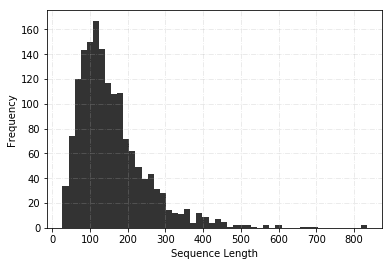

In [12]:
"""Visualize the data in histogram format"""
%matplotlib inline
plt.grid(linestyle='-.',alpha=0.3)
plt.hist(numWords, 50, color="black", alpha=0.8)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
wordsVectors = []
notFoundwords = []
for word in vocabulary:
    try:
        vector = w2v_model[word]
        wordsVectors.append(vector)
    except Exception as e:
        notFoundwords.append(word)
        wordsVectors.append(np.random.uniform(-0.25,0.25,300))  

del w2v_model
wordsVectors = np.asarray(wordsVectors)

print('The number of missing words is ', len(notFoundwords))

"""Save"""
pickle_file = os.path.join('/Users/cosgalaxy/Desktop/cnn/', 'save.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'wordsVectors': wordsVectors,
        'vocabulary': vocabulary,
        'notFoundwords': notFoundwords
    }

    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

The number of missing words is  894
Compressed pickle size: 23348879


In [9]:
MAX_SEQ_LENGTH = 160
def convertFileToIndexArray(filePath):
    doc = np.zeros(MAX_SEQ_LENGTH, dtype='int32')
    with open(filePath, "r") as f:
        lines=f.readlines()
        indexCounter = 0
        for line in lines:
            cleanedLine = clean_str(line)
            cleanedLine = cleanedLine.strip()
            cleanedLine = cleanedLine.lower()
            words = cleanedLine.split(' ')
            for word in words:
                doc[indexCounter] = vocabulary.index(word)
                indexCounter = indexCounter + 1
                if (indexCounter >= MAX_SEQ_LENGTH):
                    break
            if (indexCounter >= MAX_SEQ_LENGTH):
                break
    return doc

totalFiles = len(truthful_reviews_link) + len(deceptive_reviews_link)
idsMatrix = np.ndarray(shape=(totalFiles, MAX_SEQ_LENGTH), dtype='int32')
labels = np.ndarray(shape=(totalFiles, 2), dtype='int32')

counter = 0
for filePath in truthful_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1

for filePath in deceptive_reviews_link:
    idsMatrix[counter] = convertFileToIndexArray(filePath)
    counter = counter + 1
    
labels[0:len(truthful_reviews_link)] = np.array([1, 0])
labels[len(truthful_reviews_link):totalFiles] = np.array([0, 1])

print('The shape of the ids matrix is ', idsMatrix.shape)
print('The shape of the labels is ', labels.shape)


The shape of the ids matrix is  (1600, 160)
The shape of the labels is  (1600, 2)


In [10]:
"""
Create a training set, a validation set and a test set after mixing the data
80% for the training set
10% for the validation set
10% for the test set
"""
size = idsMatrix.shape[0]
testSize = int(size * 0.1)
shuffledIndex = np.random.permutation(size)
testIndexes = shuffledIndex[0:testSize]
validationIndexes = shuffledIndex[testSize:2*testSize]
trainIndexes = shuffledIndex[2*testSize:size]

test_data = idsMatrix[testIndexes]
test_labels = labels[testIndexes]

validation_data = idsMatrix[validationIndexes]
validation_labels = labels[validationIndexes]

train_data = idsMatrix[trainIndexes]
train_labels = labels[trainIndexes]

print('train data shape ', train_data.shape)
print('train labels shape ', train_labels.shape)
print('validation data shape ', validation_data.shape)
print('validation labels shape ', validation_labels.shape)
print('test data shape ', test_data.shape)
print('test labels shape ', test_labels.shape)

pickle_file = os.path.join('/Users/cosgalaxy/Desktop/cnn/', 'data_saved.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data,
        'train_labels': train_labels,
        'validation_data': validation_data,
        'validation_labels': validation_labels,
        'test_data': test_data,
        'test_labels': test_labels
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

train data shape  (1280, 160)
train labels shape  (1280, 2)
validation data shape  (160, 160)
validation labels shape  (160, 2)
test data shape  (160, 160)
test labels shape  (160, 2)
Compressed pickle size: 1037254
